<a href="https://colab.research.google.com/github/ritwiks9635/CNN_Project_File/blob/main/Image_Segmentation_using_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**https://www.kaggle.com/datasets/tapakah68/supervisely-filtered-segmentation-person-dataset**

In [ ]:
!unzip /content/https:/www.kaggle.com/datasets/tapakah68/supervisely-filtered-segmentation-person-dataset/supervisely-filtered-segmentation-person-dataset.zip

In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

In [4]:
import sys
sys.path.append('/content/supervisely_person_clean_2667_img')

In [5]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [6]:
CSV_FILE = '/content/df.csv'
DATA_DIR = '/content/supervisely_person_clean_2667_img/supervisely_person_clean_2667_img/'

DEVICE = 'cuda'

EPOCHS = 25
LR = 0.003
IMAGE_SIZE = 320
BATCH_SIZE = 16

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [7]:
data = pd.read_csv(CSV_FILE)
#print(data.head())
print(data.shape)

(2667, 4)


In [8]:
data.head()

,Unnamed: 0,images,masks,collages
0,0,images/ds10_pexels-photo-687782.png,masks/ds10_pexels-photo-687782.png,collage/ds10_pexels-photo-687782.jpg
1,1,images/ds10_pexels-photo-835971.png,masks/ds10_pexels-photo-835971.png,collage/ds10_pexels-photo-835971.jpg
2,2,images/ds10_pexels-photo-850708.png,masks/ds10_pexels-photo-850708.png,collage/ds10_pexels-photo-850708.jpg
3,3,images/ds10_pexels-photo-864937.png,masks/ds10_pexels-photo-864937.png,collage/ds10_pexels-photo-864937.jpg
4,4,images/ds10_pexels-photo-865908.png,masks/ds10_pexels-photo-865908.png,collage/ds10_pexels-photo-865908.jpg


In [9]:
data.drop(["collages", "Unnamed: 0"], axis=1, inplace=True)

In [10]:
data = data.head(300)
data.shape

(300, 2)

In [11]:
data.head(1)

,images,masks
0,images/ds10_pexels-photo-687782.png,masks/ds10_pexels-photo-687782.png


In [12]:
row = data.iloc[4]

image_path = DATA_DIR + row.images
mask_path = DATA_DIR + row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0

print("Image shape is :: ", image.shape)
print("mask shaps is :: ", mask.shape)

Image shape is ::  (800, 1422, 3)
mask shaps is ::  (800, 1422)


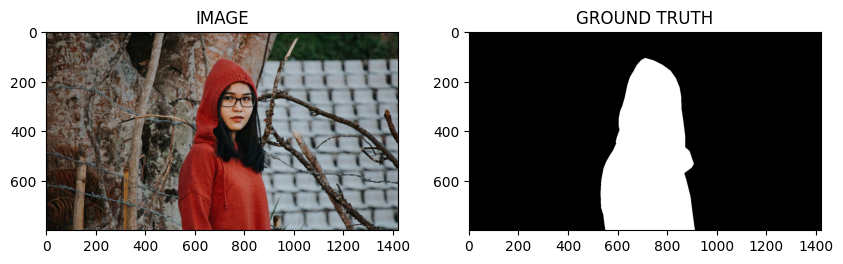

In [13]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')

ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [14]:
train_ds, valid_ds = train_test_split(data, test_size = 0.2, random_state = 42)


#**Augmentation Functions**
albumentation documentation : https://albumentations.ai/docs/

In [15]:
import albumentations as A

In [16]:
def get_train_augs():
  return A.Compose([
                    A.Resize(IMAGE_SIZE, IMAGE_SIZE),
                    A.HorizontalFlip(p=0.5),  # chance of flip
                    A.VerticalFlip(p=0.5)
  ])

def get_valid_augs():
  return A.Compose([
                    A.Resize(IMAGE_SIZE, IMAGE_SIZE)
  ])

In [17]:
from torch.utils.data import Dataset

In [18]:
class SegmentationDataset(Dataset):
  def __init__(self, df, augmentations):
      self.df = df
      self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
      row = self.df.iloc[idx]

      image_path = DATA_DIR + row.images
      mask_path = DATA_DIR + row.masks

      image = cv2.imread(image_path)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # (h, w, c)

      mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # (h, w)
      mask = np.expand_dims(mask, axis=-1)  # (h, w, c)

      if self.augmentations:
        data = self.augmentations(image=image, mask=mask)
        image = data['image'] # (h, w, c)
        mask = data['mask']

      # shift (h, w, c) -> (c, h, w) since we use PyTorch
      image = np.transpose(image, (2, 0, 1)).astype(np.float32)  # c:axis=2
      mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)

      # convert to Tensor
      image = torch.Tensor(image) / 255.0
      mask = torch.round(torch.Tensor(mask) / 255.0)  # to 0 and 1 (we have 2 classes)

      return image, mask

In [19]:
trainset = SegmentationDataset(train_ds, get_train_augs())
validset = SegmentationDataset(valid_ds, get_valid_augs())

In [20]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 240
Size of Validset : 60


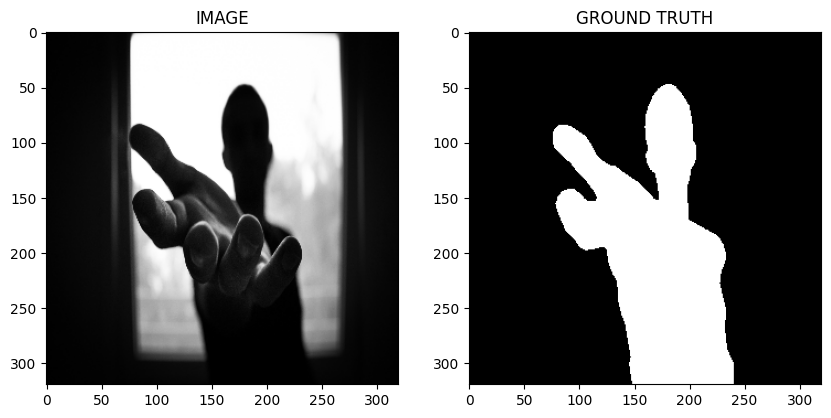

In [21]:
idx = 4

image, mask= trainset[idx]

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image.permute(1, 2, 0))

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask.permute(1, 2, 0),cmap = 'gray')

#**Load dataset into batches**

In [22]:
from torch.utils.data import DataLoader

In [23]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)

In [24]:
print("total no of Batchs in trainloader ::", len(trainloader))
print("total no of Batchs in validloader ::", len(validloader))

total no of Batchs in trainloader :: 15
total no of Batchs in validloader :: 4


In [25]:
for image, mask in trainloader:
    print(f'One batch image shape : {image.shape}')
    print(f'One batch mask shape : {mask.shape}')
    break

One batch image shape : torch.Size([16, 3, 320, 320])
One batch mask shape : torch.Size([16, 1, 320, 320])



#**Create Segmentation Model**
segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [26]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [27]:
class SegmentationModel(nn.Module):
  def __init__(self) -> None:
      super(SegmentationModel, self).__init__() # usually do to create model in Pytorch

      self.arc = smp.Unet(
          encoder_name=ENCODER,
          encoder_weights=WEIGHTS,
          in_channels=3,
          classes=1,
          activation=None # output logits will be raw
      )

  def forward(self, images, masks=None):
    logits = self.arc(images)

    if masks != None: # must use != else does not run in training: "Boolean value of Tensor with more than one value is ambiguous"
      loss1 = DiceLoss(mode='binary')(logits, masks)
      loss2 = nn.BCEWithLogitsLoss()(logits, masks)
      return logits, loss1 + loss2

    return logits

In [28]:
model = SegmentationModel()
model.to(DEVICE)

Downloading: "https://github.com/huggingface/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0-0af12548.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0-0af12548.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 85.9MB/s]


SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
           

#**Create Train and Validation Function**

In [29]:
def train_fn(data_loader: DataLoader, model: SegmentationModel, optimizer):
  model.train()
  total_loss = 0.0

  for images, masks in tqdm(data_loader):
    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(data_loader)

In [30]:
def eval_fn(data_loader: DataLoader, model: SegmentationModel):
  model.eval()
  total_loss = 0.0

  with torch.no_grad():
    for images, masks in tqdm(data_loader):
      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      logits, loss = model(images, masks)

      total_loss += loss.item()

    return total_loss / len(data_loader)

#**Train Model**

In [31]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [33]:
best_valid_loss = np.Inf

for i in range(EPOCHS):
  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt') # .pt = pytorch
    print('SAVED-MODEL')
    best_valid_loss = valid_loss

  print(f'Epoch: {i+1} Train_loss: {train_loss} Valid_loss: {valid_loss}')

100%|██████████| 4/4 [00:02<00:00,  1.89it/s]


SAVED-MODEL
Epoch: 1 Train_loss: 0.12967325101296107 Valid_loss: 0.2498706467449665


100%|██████████| 4/4 [00:04<00:00,  1.09s/it]


SAVED-MODEL
Epoch: 2 Train_loss: 0.13686422010262808 Valid_loss: 0.24077201262116432


100%|██████████| 4/4 [00:02<00:00,  1.86it/s]


Epoch: 3 Train_loss: 0.13352970381577808 Valid_loss: 0.26128361746668816


100%|██████████| 4/4 [00:02<00:00,  1.87it/s]


Epoch: 4 Train_loss: 0.11141839772462844 Valid_loss: 0.24802083149552345


100%|██████████| 4/4 [00:02<00:00,  1.88it/s]


Epoch: 5 Train_loss: 0.11157534271478653 Valid_loss: 0.40550408512353897


100%|██████████| 4/4 [00:02<00:00,  1.85it/s]


Epoch: 6 Train_loss: 0.10577783584594727 Valid_loss: 0.2640894278883934


100%|██████████| 4/4 [00:02<00:00,  1.60it/s]


Epoch: 7 Train_loss: 0.08619368001818657 Valid_loss: 0.24850750342011452


100%|██████████| 4/4 [00:02<00:00,  1.64it/s]


Epoch: 8 Train_loss: 0.0826851432522138 Valid_loss: 0.2719924822449684


100%|██████████| 4/4 [00:02<00:00,  1.85it/s]


Epoch: 9 Train_loss: 0.09040204087893168 Valid_loss: 0.2974402979016304


100%|██████████| 4/4 [00:02<00:00,  1.87it/s]


SAVED-MODEL
Epoch: 10 Train_loss: 0.11009080559015275 Valid_loss: 0.2311861515045166


100%|██████████| 4/4 [00:02<00:00,  1.84it/s]


Epoch: 11 Train_loss: 0.11445730775594712 Valid_loss: 0.24639583006501198


100%|██████████| 4/4 [00:02<00:00,  1.80it/s]


Epoch: 12 Train_loss: 0.09816941544413567 Valid_loss: 0.24447550997138023


100%|██████████| 4/4 [00:02<00:00,  1.48it/s]


Epoch: 13 Train_loss: 0.10519087910652161 Valid_loss: 0.26887717843055725


100%|██████████| 4/4 [00:02<00:00,  1.88it/s]


Epoch: 14 Train_loss: 0.09530086020628611 Valid_loss: 0.28354839235544205


100%|██████████| 4/4 [00:02<00:00,  1.84it/s]


Epoch: 15 Train_loss: 0.10629119152824083 Valid_loss: 0.2825831472873688


100%|██████████| 4/4 [00:02<00:00,  1.87it/s]


Epoch: 16 Train_loss: 0.09379296253124873 Valid_loss: 0.3327171802520752


100%|██████████| 4/4 [00:02<00:00,  1.83it/s]


Epoch: 17 Train_loss: 0.11207887430985769 Valid_loss: 0.2597382962703705


100%|██████████| 4/4 [00:02<00:00,  1.69it/s]


Epoch: 18 Train_loss: 0.09743747711181641 Valid_loss: 0.2552276439964771


100%|██████████| 4/4 [00:02<00:00,  1.55it/s]


Epoch: 19 Train_loss: 0.08596080541610718 Valid_loss: 0.25177302956581116


100%|██████████| 4/4 [00:02<00:00,  1.55it/s]


SAVED-MODEL
Epoch: 20 Train_loss: 0.07240102340777715 Valid_loss: 0.22292396798729897


100%|██████████| 4/4 [00:02<00:00,  1.86it/s]


Epoch: 21 Train_loss: 0.06954861556490262 Valid_loss: 0.2236391380429268


100%|██████████| 4/4 [00:02<00:00,  1.86it/s]


Epoch: 22 Train_loss: 0.06581867933273315 Valid_loss: 0.2327810563147068


100%|██████████| 4/4 [00:02<00:00,  1.85it/s]


Epoch: 23 Train_loss: 0.06083569253484408 Valid_loss: 0.22459880262613297


100%|██████████| 4/4 [00:02<00:00,  1.61it/s]


Epoch: 24 Train_loss: 0.05883483439683914 Valid_loss: 0.24711313098669052


100%|██████████| 4/4 [00:02<00:00,  1.61it/s]

Epoch: 25 Train_loss: 0.06888102442026138 Valid_loss: 0.2632545158267021


#**Inference**

In [46]:
idx = 3

model.load_state_dict(torch.load('/content/best_model.pt'))

image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze (0))  # (C, H, W) -> (1, C, H, W) where 1 is batch size just to use sigmoid
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5) * 1.0

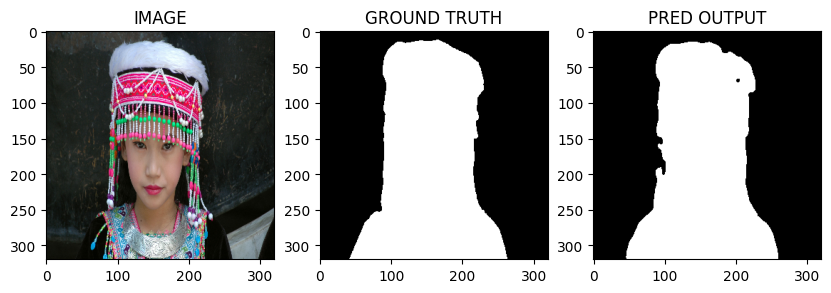

In [47]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image.permute(1, 2, 0))

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask.permute(1, 2, 0),cmap = 'gray')

ax3.set_title('PRED OUTPUT')
ax3.imshow(pred_mask.detach().cpu().squeeze(0).permute(1, 2, 0), cmap = 'gray')